**import packages used**

In [1]:
import numpy as np
import random
from pyXRD import pyXRDCodes
from scipy.signal import find_peaks
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Corrected

In [265]:
class Structure:
    def __init__(self, atoms, positions,symmetry, unit_params,unit_angles,structure,theta,hkls,counts,step = 0.01):
        self.atoms = atoms  # List of atom types (e.g., ['Ti', 'C'])
        self.positions = positions  # List of positions for each atom type
        self.unit_params = unit_params  # Unit cell parameters
        self.unit_angles = unit_angles
        self.structure = structure
        self.symnumb = symmetry
        self.symmetry = pyXRDCodes.get_symmetry_operations_number(symmetry)
        self.thetas = theta
        self.hkls = hkls
        self.counts = counts

        self.steps = step
        self.params_grid = np.arange(0,1,step)

        # Store original atom counts
        self.original_atom_counts = {atom: len(pos_list) for atom, pos_list in zip(atoms, positions)}

        if structure == 'triclinic':
            self.group_sym = np.array([1,2])
        if structure == 'monoclinic':
            self.group_sym = np.arange(3,16,1)
        if structure == 'orthorombic':
            self.group_sym = np.arange(16,75,1)
        if structure == 'tetragonal':
            self.group_sym = np.arange(75,143,1)
        if structure == 'hexagonal':
            self.group_sym = np.arange(143,195,1)
        if structure == 'trigonal':
            self.group_sym = np.arange(143,168,1)
        if structure == 'cubic':
            self.group_sym = np.arange(195,231,1)

    def get_primit_unit(self):
        ppos_primit = [
        [ h
            for pos in atom_list
            for h in pyXRDCodes.POS(pos, self.symmetry)
        ]  for atom_list in self.positions    ]
    
        primit = []
        for i in range(len(ppos_primit)):
            pp = []
            verif = []
            for j in range(len(ppos_primit[i])):
                vec = ppos_primit[i][j]
                if 0 <= vec[0] < 1 and 0 <= vec[1] < 1 and 0 <= vec[2] < 1:
                    cart = tuple(np.round(pyXRDCodes.abcToxyz(vec, self.unit_params, self.unit_angles) ,2))
                    if cart not in verif:
                        verif.append(cart)
                        pp.append(pyXRDCodes.abcToxyz(vec, self.unit_params, self.unit_angles))
            primit.append(pp)
        #primit,pos_unit,_ = pyXRDCodes.find_atoms_unit_cell(self.positions, self.unit_params, self.unit_angles, self.symmetry)        
        return primit,self.positions#pos_unit


    #Give the real xyz positions
    def true_positions(self,pos):
        """
        Function to give positions to use in the 'simulate_xrd' function
        """
        positions = []
        for i in range(len(self.atoms)):
            pp = []
            for j in range(len(pos[i])):
                pp.append(pyXRDCodes.abcToxyz(pos[i][j],self.unit_params,self.unit_angles))
            positions.append( pp )
        
        return positions


    # --- Simulation Methods ---
    def calculate_xrd(self, lamb):
        """
        Simulates X-ray diffraction (XRD) pattern based on the structure's parameters.
        Returns a simulated XRD intensity pattern.
        """
        primit,unit_pos = self.get_primit_unit()

        data = pyXRDCodes.Intensid_xrd(
            lamb,self.hkls,self.thetas,self.counts,
            self.unit_params,
            self.unit_angles,
            primit,
            self.atoms)

        theta2 = np.array(data['two_thetas'])
        intensities = np.array(data['intensities'])
        if len(intensities) == 0:
            return np.array([0]),np.array([0])
        
        intensities = intensities / np.max(intensities)

        return theta2,intensities

    def mutate(self, change_prob = 0.8 ,shuffle_prob = 0.1 ,change_sym = 0.1,
               change_atom = 0.2,max_shift = 35 , only_alter_pos=False):
        """
        Mutates the structure by randomly changing atom types and slightly perturbing atomic positions
        and unit cell parameters. The atoms and positions are flattened and shuffled. Each atom may 
        randomly change to a different atom with probability `change_prob`.
        
        Args:
            preserve_all_atoms (bool): If True, ensures at least one of each original atom remains.
        """

        # Flatten atoms and positions into one list
        flat_positions,verif_pos = self.flat_positions(self.atoms.copy(),self.positions.copy(),max_shift=0.00)

        
        new_flat = []
        i = 0
        for atom, pos in flat_positions:
            new_pos = pos.copy()
            new_atom = atom         
            # Position movement
            if random.random()<change_prob:
                shift = np.random.randint(-max_shift, max_shift+1, size=3)
                new_pos = list(np.round(abs(new_pos + shift*self.steps) % 1,2))  # Wrap around unit cell
            # Position shuffle
            if random.random() < shuffle_prob:
                new_pos = list(random.sample(new_pos, 3))
            #Change the position of two atoms
            if random.random() <change_atom:
                idxs = np.arange(0,len(flat_positions),1)
                possib_new_atom = random.choice(idxs[idxs!=i])
                n_pos = flat_positions[possib_new_atom][1].copy()
                flat_positions[possib_new_atom] = (flat_positions[possib_new_atom][0],new_pos.copy())
                new_pos = n_pos
                
            new_flat.append((new_atom, new_pos ))
            i+=1

            if random.random() <change_sym:
                self.symnumb = random.choice(self.group_sym[self.group_sym!=self.symnumb])
                self.symmetry = pyXRDCodes.get_symmetry_operations_number(self.symnumb)
        # Rebuild grouped structure
        atomss ,poss = self.unflatten_positions(new_flat.copy())
        self.atoms = atomss.copy()
        self.positions = poss.copy()
       
        
    def crossover(self, other, inherit_prob=0.5):
        """
        Performs crossover while ensuring no atom type exceeds `max_atoms_per_atom`.
        Args:
            inherit_prob (float): Probability of taking a position from self (parent 1).
            max_atoms_per_atom (int): Max allowed positions per atom type in the child.
            preserve_atoms (bool): If True, ensures at least one of each atom type remains.
        """
        child = self.copy()

        # Flatten positions of both parents
        flat_self, _ = self.flat_positions(self.atoms.copy(), self.positions.copy(), max_shift=0.00)
        flat_self = random.sample(flat_self, len(flat_self))
        flat_other, _ = self.flat_positions(other.atoms.copy(), other.positions.copy(), max_shift=0.00)
        flat_other = random.sample(flat_other, len(flat_other))

        # Create combined list of all unique atom types
        all_atoms = list(set(self.atoms) | set(other.atoms))
        combined = []
        atom_counts = {atom: 0 for atom in all_atoms}

        # Process each atom type separately
        for atom,pos in flat_self:
            new_pos = pos.copy()
            S=True
            for other_atom,other_pos in flat_other:
                if atom == other_atom:
                    if random.random() < inherit_prob and S:
                        new_pos = other_pos.copy()
                        flat_other.remove( (other_atom,other_pos))
                        S=False

            combined.append( (atom, list( np.round(abs(np.array(new_pos + np.random.randint(-10,11,3)*self.steps))%1,2) ) ) )

        # See If atoms are overlapping

        combined = self.separate_overlaps(combined)

        # Rebuild atom and position lists
        atoms_new, pos_new = self.unflatten_positions(combined.copy())
        child.atoms = atoms_new
        child.positions = pos_new

        # Randomly inherit symmetry from either parent
        if random.random() > inherit_prob:
            child.symnumb = other.symnumb
            child.symmetry = other.symmetry

        return child

    #HELPER
    def copy(self):
        return Structure(self.atoms.copy(), self.positions.copy(),self.symnumb, self.unit_params.copy(),self.unit_angles.copy(),
                         self.structure,self.thetas.copy(),self.hkls.copy(),self.counts.copy())
    #Function to flatten positions
    def flat_positions(self,ATOMS,POS,max_shift):
        flat_positions = []
        verif_pos = []
        for atom, pos_list in zip(ATOMS, POS):
            for pos in pos_list:
                flat_positions.append((atom, list(abs(np.array(pos).copy() + np.random.uniform(max_shift, max_shift, 3)) % 1) ))
                verif_pos.append(flat_positions[-1][1])
        return flat_positions,verif_pos

    def unflatten_positions(self,flat_pos):
        atom_to_pos = {}
        for atom, pos in flat_pos:
            atom_to_pos.setdefault(atom, []).append(pos)

        atoms = list(atom_to_pos.keys())
        positions = list(atom_to_pos.values())  
        return atoms,positions
    def contains_position(self, pos, atom_pos_list, tol=1e-2):
        """
        Checks if a given position is already present in a list of (atom, position) tuples,
        within a specified tolerance.
        """
        for _, existing_pos in atom_pos_list:
            if np.linalg.norm(np.array(pos) - np.array(existing_pos)) < tol:
                return True
        return False

    def separate_overlaps(self, atom_positions, min_dist=0.1, target_dist=0.25):
        """
        Separates atoms that are closer than min_dist to target_dist apart.
        Uses minimum image convention for periodic boundaries.
        """
        positions = [(atom, np.array(pos)) for atom, pos in atom_positions]
        n_atoms = len(positions)
        changed = True
        
        while changed:
            changed = False
            for i in range(n_atoms):
                for j in range(i+1, n_atoms):
                    atom_i, pos_i = positions[i]
                    atom_j, pos_j = positions[j]
                    
                    # Minimum image convention
                    delta = np.array(pos_i) - np.array(pos_j)
                    delta = delta - np.round(delta)
                    distance = np.linalg.norm(delta)
                    
                    if 0 < distance < min_dist:
                        changed = True
                        direction = delta / (distance + 1e-10)  # Avoid division by zero
                        
                        # Calculate movement needed
                        move = (target_dist - distance) / 2
                        
                        # Move atoms apart
                        new_pos_i = abs(np.array(pos_i) + move * direction) % 1
                        new_pos_j = abs(np.array(pos_j) - move * direction) % 1
                        
                        positions[i] = (atom_i, list(new_pos_i))
                        positions[j] = (atom_j, list(new_pos_j))
        return [(atom, list(pos)) for atom, pos in positions]

In [266]:
def generate_initial_pop(size_pop,atom,size_atom,unit_params,unit_angles,structure,lamb):
    if structure == 'triclinic':
        group_sym = np.array([1,2])
    if structure == 'monoclinic':
        group_sym = np.arange(3,16,1)
    if structure == 'orthorombic':
        group_sym = np.arange(16,75,1)
    if structure == 'tetragonal':
        group_sym = np.arange(75,143,1)
    if structure == 'hexagonal':
        group_sym = np.arange(143,195,1)
    if structure == 'trigonal':
        group_sym = np.arange(143,168,1)
    if structure == 'cubic':
        group_sym = np.arange(195,231,1)

    hkls, counts, thetas, Gs = pyXRDCodes.generate_hkls(lamb,10, np.array(unit_params), np.array(unit_angles))
    param_grid = np.arange(0,1,0.01)
    population = []
    symme = np.random.choice(group_sym,size_pop)
    
    tries = 0
    while len(population) <size_pop or tries<size_pop*2:
        pos = []
        for i in range(len(atom)):
            size = size_atom[i]
            all_a = np.random.choice(param_grid, size )
            all_c = np.random.choice(param_grid, size )
            all_b = np.random.choice(param_grid, size )
            pos.append( [ [all_a[j],all_b[j] ,all_c[j]] for j in range(size) ] )
        struct = Structure(atom,pos,symme[i],unit_params,unit_angles,structure,thetas,hkls,counts)
        if struct:
            population.append(struct)
        tries+=1

    return population

In [268]:
def compute_fitness(struct, theta2_exp, int_exp, lamb, bounds=1):
    # Calculate XRD pattern from structure
    theta2, int_calc = struct.calculate_xrd(lamb)
    
    # Filter to relevant angular range
    mask = (theta2 >= min(theta2_exp)-2) & (theta2 <= max(theta2_exp)+2)
    theta2 = np.array(theta2)[mask]
    int_calc = np.array(int_calc)[mask]

    if len(theta2) == 0:
        return 1e6  # Return high penalty if no peaks
    
    # Normalize intensities
    int_calc = 10*int_calc / max(int_calc) if max(int_calc) > 0 else int_calc
    int_exp = 10*int_exp / max(int_exp)
    
    # Create a working copy of experimental intensities
    remaining_intensity = int_exp.copy()
    unmatched = 0
    
    # For each calculated peak, find and subtract matching experimental peak
    for t_calc, i_calc in zip(theta2, int_calc):
        # Find closest experimental peak within tolerance
        angle_diffs = np.abs(theta2_exp - t_calc)
        closest_idx = np.argmin(angle_diffs)
        
        if angle_diffs[closest_idx] <= 0.02:  # 0.1 degree tolerance
            # Subtract what we can match (up to remaining intensity)
            remaining_intensity[closest_idx] = abs(remaining_intensity[closest_idx] - i_calc)
        else:
            unmatched+=i_calc
    
    # The error is the sum of remaining intensities (what wasn't matched)
    total_error = np.sum(remaining_intensity)
    
    return total_error + unmatched

In [ ]:
def run_ga(observed_theta,
        observed_int,
        lamb,
        atom,
        size_atom ,
        unit_param,
        unit_angle,
        structu,
        generations = 40,
        numb_pop = 40,
        elit_frac = 0.1,
        change_prob = 1,
        change_atom = 0.2,
        shuffle_prob = 0.1,
        change_sym = 0.2,
        max_shift = 35,
        early_stag = 15,
        inherit_prob=0.7,
        limit_min = 0.06,
        power = 2,
        bounds = [5,170]):
    
    _,_,alltheta2,_ = pyXRDCodes.generate_hkls(lamb,10,np.array(unit_params),np.array(unit_angles))
    # Initialize population with diverse crystal systems
    population = generate_initial_pop(numb_pop,atom,size_atom,unit_param,unit_angle,structu,lamb)
    history = []
    best_score = []
    Best_Hist = []

    # Track best solution
    best_fitness = float('inf')
    best_cell = None
    no_improvement = 0
    
    for gen in range(generations):
        fitness_scores = [np.round(compute_fitness(s, observed_theta, observed_int,lamb,bounds = bounds,power=power),4) for s in population]
        # Check for new best solution
        current_best = min(fitness_scores)
        if current_best < best_fitness:
            best_fitness = current_best
            best_cell = population[np.argmin(fitness_scores)].copy()
            history.append(best_cell)
            best_score.append(best_fitness)
            no_improvement = 1
        else:
            no_improvement += 1
        
        
        if best_fitness<=limit_min:
            print(f"Early stopping at generation {gen+1}")
            break
        #=======================================================================
        # Stagnation if no improvement for several generations
        if no_improvement >= early_stag:
            print(f"Stagnation found at {gen+1}")

            elite_size = max(1, int(elit_frac * len(population)))
            elite_indices = np.argsort(fitness_scores)[:elite_size]
            
            elites = [population[i] for i in elite_indices]
            pre_population = elites.copy()

            fresh_size = int(numb_pop * 0.5)
            while len(pre_population) < elite_size + fresh_size:
                random_individual = generate_initial_pop(2, atom,size_atom, unit_param, unit_angle, structu, lamb)[0]
                pre_population.append(random_individual)
            
            # Fill rest with mutated elites
            while len(pre_population) < numb_pop:
                base = random.choice(elites).copy()
                base.mutate( change_prob = 0.8, shuffle_prob=0.3,
                          max_shift = 45, change_sym=0.5,change_atom = 0.3, only_alter_pos=False)
                pre_population.append(base)

            population = pre_population
            fitness_scores = [np.round(compute_fitness(s, observed_theta, observed_int,lamb,bounds = bounds,power=power),4) for s in pre_population]
            current_best = min(fitness_scores)
            population = pre_population

            # Ver se melhor estrutura foi obtida
            if current_best < best_fitness:
                best_fitness = current_best
                best_cell = population[np.argmin(fitness_scores)].copy()
                history.append(best_cell.copy())
                best_score.append(best_fitness)
            no_improvement = 1
        #===================================================================

        Best_Hist.append(best_cell.copy())

        # Selection - tournament selection
        new_population = []
        
        # Elitism - keep the best individuals
        elite_size = max(1, int(elit_frac * len(population)))
        elite_indices = np.argsort(fitness_scores)[:elite_size]
        Elite = [population[i] for i in elite_indices]
        new_population.extend(Elite)

        
        # Roulette-wheel selection loop
        while len(new_population) < numb_pop:
            parent1 = np.random.choice(population)
            parent2 = np.random.choice(population)
            
            child = parent1.crossover(parent2, inherit_prob)
            child.mutate( change_prob = change_prob, shuffle_prob=shuffle_prob,change_atom = change_atom,
                          max_shift = max_shift, change_sym=change_sym,only_alter_pos=False)
            new_population.append(child)

        
        population = new_population
        #history.append(population)
        print(f"Generation {gen+1}, Best Fitness: {best_fitness:.3f}")
    
    fitness_scores = [np.round(compute_fitness(s, observed_theta, observed_int,lamb,bounds = bounds,power=power),4) for s in population]
        # Check for new best solution
    current_best = min(fitness_scores)
    if current_best < best_fitness:
        best_fitness = current_best
        best_cell = population[np.argmin(fitness_scores)].copy()
        history.append(best_cell.copy())
        best_score.append(best_fitness)

    Best_Hist.append(best_cell.copy())
    best_value = np.argsort(best_score)
    return best_cell,history,best_score,Best_Hist

In [308]:
lamb = 1.54
atoms = ['Ti','C']
positions = [ [[0,0,0],[1/2,1/2,0] ] , [[1/4,0,1/2]] ]
unit_params = [2,2,9]
unit_angles = [90,90,120]
structure = 'hexagonal'
symm = 194
hkls, counts, thetas, Gs = pyXRDCodes.generate_hkls(lamb,10, np.array(unit_params), np.array(unit_angles)) #<--- edited here
model1 = Structure( atoms, positions,symm, unit_params,unit_angles,structure,thetas,hkls,counts)
observed_theta,U = model1.calculate_xrd(lamb)
compute_fitness(model1 , observed_theta,U , lamb,[5,170],power=3 )

-1.0000000000000007

In [310]:
lamb = 1.54
atoms = ['Ti','C']
positions = [ [[0,0,0],[1/2,1/2,0] ] , [[1/4,0,1/2]] ]
unit_params = [7,5,12]
unit_angles = [70,85,110]
structure = 'triclinic'
symm = 2
hkls, counts, thetas, Gs = pyXRDCodes.generate_hkls(lamb,10, np.array(unit_params), np.array(unit_angles)) #<--- edited here
model1 = Structure( atoms, positions,symm, unit_params,unit_angles,structure,thetas,hkls,counts)
observed_theta,U = model1.calculate_xrd(lamb)

compute_fitness(model1 , observed_theta,U , lamb,2 )

-0.9999999999999999

In [312]:
lamb = 1.54
atoms = ['Ti','C']
positions = [ [[0,0,0],[1/2,1/2,0] ] , [[1/4,0,1/2]] ]
unit_params = [4,4,4]
unit_angles = [90,90,90]
structure = 'cubic'
symm = 210
hkls, counts, thetas, Gs = pyXRDCodes.generate_hkls(lamb,10, np.array(unit_params), np.array(unit_angles)) #<--- edited here
model1 = Structure( atoms, positions,symm, unit_params,unit_angles,structure,thetas,hkls,counts)
observed_theta,U = model1.calculate_xrd(lamb)
compute_fitness(model1 , observed_theta,U , lamb,[5,170] )

-1.0000000000000002

In [347]:
Best_cell,Hist,Scores,Best_Hist = run_ga(observed_theta,
        U,
        lamb,
        atoms,
        [2,1],
        unit_params,
        unit_angles,
        structure,
        generations = 900,
        numb_pop = 40,
        elit_frac = 0.1,
        change_atom = 0.2,
        change_prob = 0.4,
        inherit_prob = 0.6,
        early_stag = 10,
        shuffle_prob=0.1,
        change_sym = 0.3,
        max_shift = 25,
        power=9,
        limit_min = compute_fitness(model1 , observed_theta,U , lamb,[5,170],9 ),
        bounds = [5,100])

Generation 1, Best Fitness: -0.351
Generation 2, Best Fitness: -0.351
Generation 3, Best Fitness: -0.498
Generation 4, Best Fitness: -0.498
Generation 5, Best Fitness: -0.529
Generation 6, Best Fitness: -0.529
Generation 7, Best Fitness: -0.529
Generation 8, Best Fitness: -0.545
Generation 9, Best Fitness: -0.545
Generation 10, Best Fitness: -0.545
Generation 11, Best Fitness: -0.545
Generation 12, Best Fitness: -0.545
Generation 13, Best Fitness: -0.545
Generation 14, Best Fitness: -0.545
Generation 15, Best Fitness: -0.555
Generation 16, Best Fitness: -0.555
Generation 17, Best Fitness: -0.555
Generation 18, Best Fitness: -0.625
Generation 19, Best Fitness: -0.625
Generation 20, Best Fitness: -0.625
Generation 21, Best Fitness: -0.639
Generation 22, Best Fitness: -0.639
Generation 23, Best Fitness: -0.639
Generation 24, Best Fitness: -0.639
Generation 25, Best Fitness: -0.639
Generation 26, Best Fitness: -0.639
Generation 27, Best Fitness: -0.639
Generation 28, Best Fitness: -0.639
G

---

(17.19743483941143, 146.14170224823542)

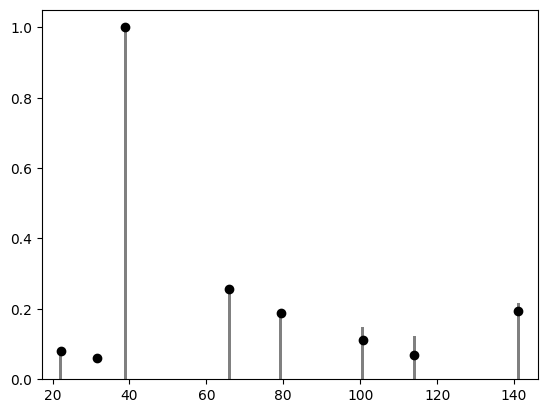

In [348]:
plt.bar(*model1.calculate_xrd(lamb) , color='gray')
plt.plot(*Best_cell.calculate_xrd(lamb) ,'o' ,color='black')

plt.xlim(min(observed_theta)-5,max(observed_theta)+5)


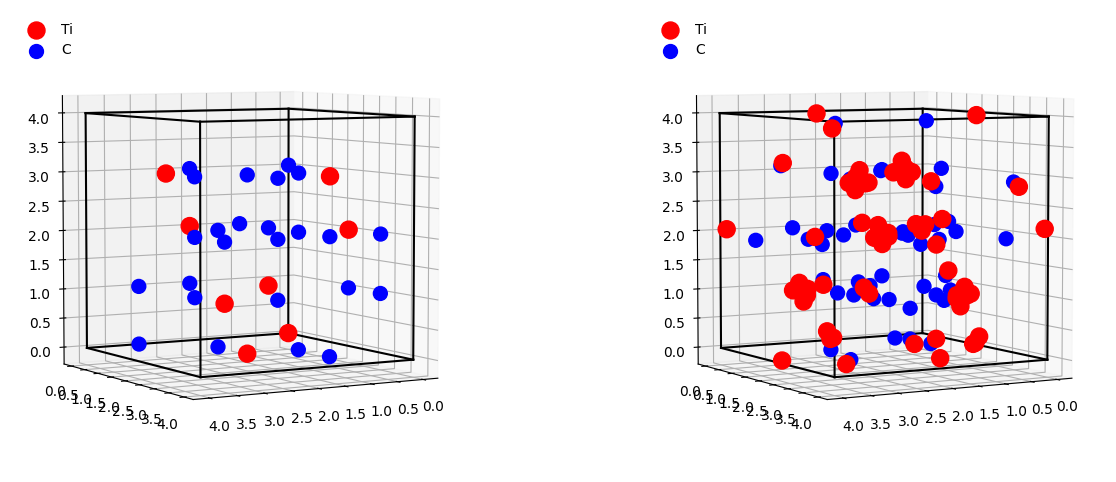

In [349]:
# Cria a figura e os subplots
fig = plt.figure(figsize=(15, 6))
gs = GridSpec(1, 2)
ax2 = fig.add_subplot(gs[0], projection='3d')  # 3D plot
ax4 = fig.add_subplot(gs[1], projection='3d')  # 3D plot
colors = ['red','blue']
Z = [30,20]

# Inicializa o plot 3D
POS__ = model1.get_primit_unit()[0]

# Extract x, y, z coordinates
points = POS__[0]
x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
ax2.scatter(x, y, z,s=5 * Z[0], color=colors[0],alpha=1, label = f'{model1.atoms[0]}')
points = POS__[1]
x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
ax2.scatter(x, y, z,s=5 * Z[1], color=colors[1],alpha=1, label = f'{model1.atoms[1]}')
#pyXRDCodes.UNIT_CELL_PLOT_HEXAGON(ax2, unit_params, unit_angles)
pyXRDCodes.UNIT_CELL_PLOT(ax2, model1.unit_params, model1.unit_angles,[1,1,1],xyz=True)
    
ax2.set_box_aspect((model1.unit_params[0], model1.unit_params[1], model1.unit_params[2]  ))
ax2.view_init(elev=5, azim=60)
ax2.legend(frameon=False,loc='upper left')

# Inicializa o plot 3D
POS__ = Best_cell.get_primit_unit()[0]
xs = [arr[0] for sublista in POS__ for arr in sublista]
ys = [arr[1] for sublista in POS__ for arr in sublista]
zs = [arr[2] for sublista in POS__ for arr in sublista]


# Extract x, y, z coordinates
points = POS__[0]
x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
ax4.scatter(x, y, z,s=5 * Z[0], color=colors[0],alpha=1, label = f'{Best_cell.atoms[0]}')
points = POS__[1]
x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
ax4.scatter(x, y, z,s=5 * Z[1], color=colors[1],alpha=1, label = f'{Best_cell.atoms[1]}')
pyXRDCodes.UNIT_CELL_PLOT(ax4, Best_cell.unit_params, Best_cell.unit_angles,[1,1,1])


ax4.set_box_aspect((Best_cell.unit_params[0], Best_cell.unit_params[1], Best_cell.unit_params[2]  ))
ax4.view_init(elev=5, azim=60)
ax4.legend(frameon=False,loc='upper left')


plt.show()

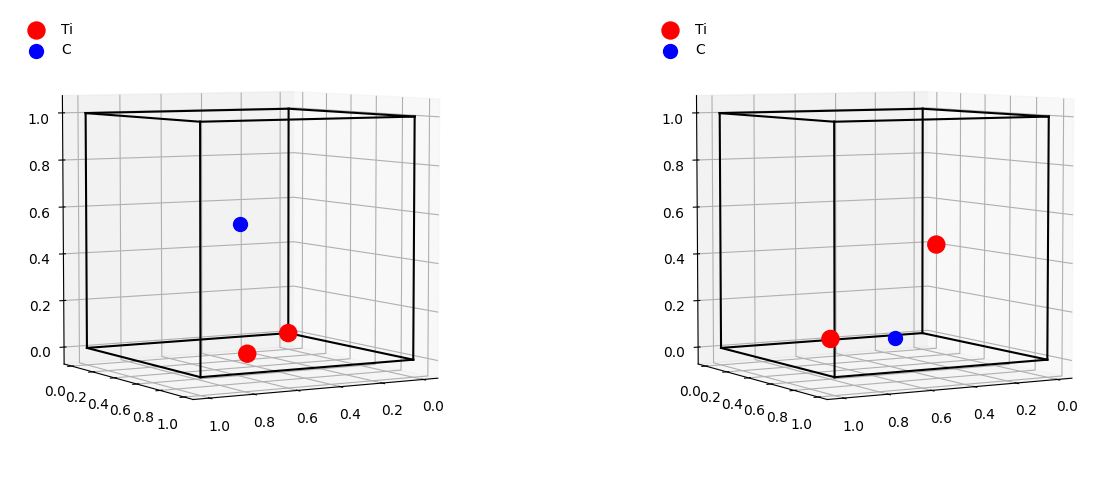

In [350]:
# Cria a figura e os subplots
fig = plt.figure(figsize=(15, 6))
gs = GridSpec(1, 2)
ax2 = fig.add_subplot(gs[0], projection='3d')  # 3D plot
ax4 = fig.add_subplot(gs[1], projection='3d')  # 3D plot
colors = ['red','blue']
Z = [30,20]

# Inicializa o plot 3D
POS__ = model1.positions#model1.true_positions(model1.positions)

# Extract x, y, z coordinates
points = POS__[0]
x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
ax2.scatter(x, y, z,s=5 * Z[0], color=colors[0],alpha=1, label = f'{model1.atoms[0]}')
points = POS__[1]
x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
ax2.scatter(x, y, z,s=5 * Z[1], color=colors[1],alpha=1, label = f'{model1.atoms[1]}')
#pyXRDCodes.UNIT_CELL_PLOT_HEXAGON(ax2, unit_params, unit_angles)
pyXRDCodes.UNIT_CELL_PLOT(ax2, model1.unit_params, model1.unit_angles,[1,1,1],xyz=False)
    
ax2.set_box_aspect((model1.unit_params[0], model1.unit_params[1], model1.unit_params[2]  ))
ax2.view_init(elev=5, azim=60)
ax2.legend(frameon=False,loc='upper left')

# Inicializa o plot 3D
POS__ = Best_cell.positions#Best_cell.true_positions(Best_cell.positions)
xs = [arr[0] for sublista in POS__ for arr in sublista]
ys = [arr[1] for sublista in POS__ for arr in sublista]
zs = [arr[2] for sublista in POS__ for arr in sublista]


# Extract x, y, z coordinates
points = POS__[0]
x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
ax4.scatter(x, y, z,s=5 * Z[0], color=colors[0],alpha=1, label = f'{Best_cell.atoms[0]}')
points = POS__[1]
x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
ax4.scatter(x, y, z,s=5 * Z[1], color=colors[1],alpha=1, label = f'{Best_cell.atoms[1]}')
pyXRDCodes.UNIT_CELL_PLOT(ax4, Best_cell.unit_params, Best_cell.unit_angles,[1,1,1],xyz=False)


ax4.set_box_aspect((Best_cell.unit_params[0], Best_cell.unit_params[1], Best_cell.unit_params[2]  ))
ax4.view_init(elev=5, azim=60)
ax4.legend(frameon=False,loc='upper left')


plt.show()

In [351]:
print(Best_cell.positions)
print(Best_cell.symnumb)
print(model1.positions)
print(model1.symnumb)


[[[0.25, 0.53, 0.45], [0.49, 0.04, 0.01]], [[0.27, 0.22, 0.02]]]
203
[[[0, 0, 0], [0.5, 0.5, 0]], [[0.25, 0, 0.5]]]
210


In [352]:
print(Best_cell.true_positions(Best_cell.positions))
print(Best_cell.symnumb)
print(model1.true_positions(model1.positions))
print(model1.symnumb)


[[array([1.  , 2.12, 1.8 ]), array([1.96, 0.16, 0.04])], [array([1.08, 0.88, 0.08])]]
203
[[array([0., 0., 0.]), array([2., 2., 0.])], [array([1.0000000e+00, 1.2246468e-16, 2.0000000e+00])]]
210


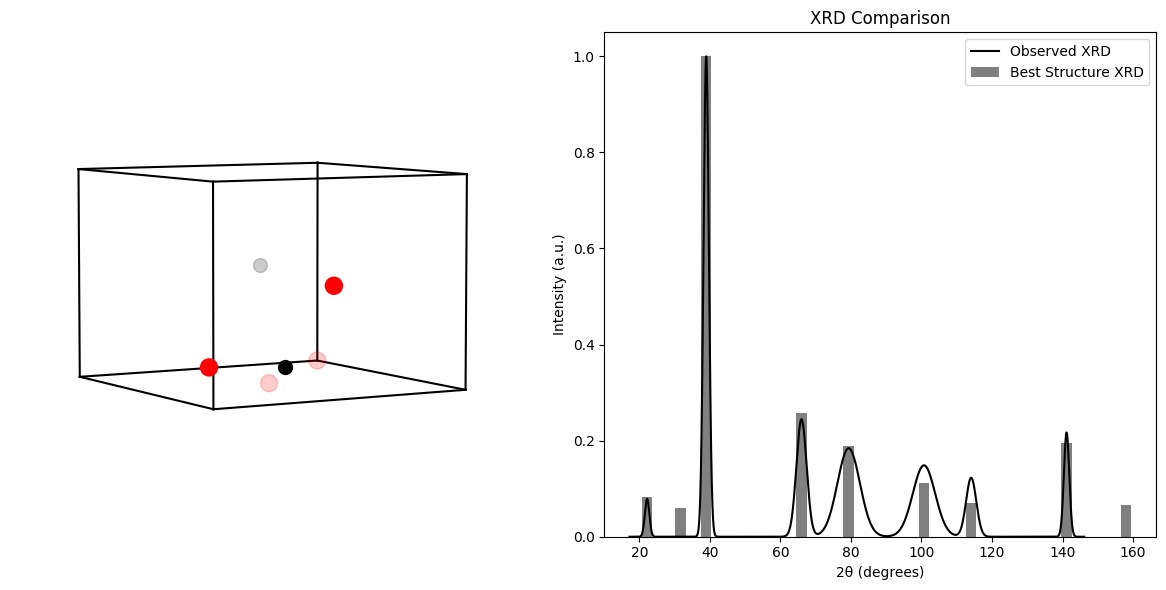

In [ ]:

#Make as IF experimental pattern
thes = np.arange(min(observed_theta)-5,max(observed_theta)+5,0.01)
sum = 0

for i in range(len(observed_theta)):
    FWHM = 0.9 * lamb / (1 * np.cos(np.radians(observed_theta[i])))  # Scherrer
    sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to sigma
    sum += U[i] * np.exp(-((thes - observed_theta[i])**2) / (2 * sigma**2))
sum = sum/max(sum)

#Define for plot
colors = ['red','black','gray']
#begin plot
fig = plt.figure(figsize=(12, 6))
    
    # --- 3D Structure Plot (Left) ---
ax1 = fig.add_subplot(121, projection='3d')
    
    # Plot IDEAL structure (semi-transparent)
POS = model1.positions
Atoms = model1.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[i], color=colors[i],alpha=0.2, label = f'{Atoms[i]}')
    
# Plot BEST structure (current generation)
POS = Best_Hist[-1].positions
Atoms = Best_Hist[-1].atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[i], color=colors[i],alpha=1, label = f'{Atoms[i]}')
pyXRDCodes.UNIT_CELL_PLOT(ax1,unit_params,unit_angles,xyz=False)
    
#ax1.set_title(f"Generation {gen}\nBest Structure (Red) vs. Ideal (Transparent)")
ax1.set_axis_off()
ax1.view_init(elev=5, azim=60)  
# --- XRD Comparison Plot (Right) ---
ax2 = fig.add_subplot(122)
    
# Calculate XRD for the best cell
theta_best, int_best = Best_cell.calculate_xrd(lamb)
 
# Plot observed and simulated XRD
ax2.plot(thes, sum, color='black', label='Observed XRD')
ax2.bar(theta_best, int_best, color='gray',width=  3, label='Best Structure XRD')
ax2.set_xlabel('2θ (degrees)')
ax2.set_ylabel('Intensity (a.u.)')
ax2.legend()
ax2.set_title("XRD Comparison")
    
plt.tight_layout()

In [354]:
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

def create_animation(Best_Hist, model1, observed_theta, U, lamb, unit_params, unit_angles, Z):
    # Prepare experimental XRD pattern
    thes = np.arange(min(observed_theta)-5, max(observed_theta)+5, 0.01)
    sum_int = np.zeros_like(thes)
    
    for i in range(len(observed_theta)):
        FWHM = 0.9 * lamb / (1 * np.cos(np.radians(observed_theta[i])))
        sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
        sum_int += U[i] * np.exp(-((thes - observed_theta[i])**2) / (2 * sigma**2))
    sum_int = sum_int/max(sum_int)

    # Define colors and initialize figure
    colors = ['red', 'black', 'gray']
    fig = plt.figure(figsize=(12, 6))
    
    # --- 3D Structure Plot (Left) ---
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Plot IDEAL structure (semi-transparent, static)
    POS_ideal = model1.positions
    Atoms_ideal = model1.atoms
    for i in range(len(POS_ideal)):
        points = POS_ideal[i]
        x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
        ax1.scatter(x, y, z, s=5*Z[i], color=colors[i], alpha=0.2, label=f'{Atoms_ideal[i]} (ideal)')
    
    # Create empty scatter plots for current structure (will be updated)
    current_scatters = []
    for i in range(len(Best_Hist[0].atoms)):  # Assuming max 3 atom types
        sc = ax1.scatter([], [], [], s=5*Z[i], color=colors[i], alpha=1.0, label=f'{Atoms_ideal[i]} (current)')
        current_scatters.append(sc)
    
    # Add unit cell
    pyXRDCodes.UNIT_CELL_PLOT(ax1, unit_params, unit_angles, xyz=False)
    ax1.set_axis_off()
    ax1.view_init(elev=5, azim=60)
    ax1.legend()
    
    # --- XRD Comparison Plot (Right) ---
    ax2 = fig.add_subplot(122)
    
    # Plot experimental XRD (static)
    ax2.plot(thes, sum_int, color='black', label='Observed XRD')
    
    # Create empty bar plot for current XRD (will be updated)
    xrd_bars = []#ax2.bar([], [], width=3, color='gray', alpha=0.7, label='Current Structure XRD')
    ax2.set_xlabel('2θ (degrees)')
    ax2.set_ylabel('Intensity (a.u.)')
    ax2.set_xlim(thes[0],thes[-1])
    ax2.legend()
    ax2.set_title("XRD Comparison")
    
    plt.tight_layout()

    def init():
        """Initialize animation with empty current structure"""
        for sc in current_scatters:
            sc._offsets3d = (np.array([]), np.array([]), np.array([]))
        
        for bar in xrd_bars:#.patches:
            bar.remove()
            #bar.set_height(0)
        xrd_bars.clear()
            
        return current_scatters #+ xrd_bars.patches

    def update(gen):
        """Update plot for current generation"""
        current_cell = Best_Hist[gen]
        
        # Update atomic positions
        POS_current = current_cell.positions
        Atoms_current = current_cell.atoms
        
        # Clear previous positions
        for sc in current_scatters:
            sc._offsets3d = (np.array([]), np.array([]), np.array([]))
        
        # Update with current positions
        for i in range(len(Atoms_current)):
            points = POS_current[i]
            x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
            current_scatters[i]._offsets3d = (x, y, z)
        
        # Update XRD bars
        theta_best, int_best = current_cell.calculate_xrd(lamb)
        
        # Clear previous bars
        #for bar in xrd_bars.patches:
        #    bar.set_height(0)
        for bar in xrd_bars:
            bar.remove()
        xrd_bars.clear()
        # Update bar heights and positions
        for i, (theta, intensity) in enumerate(zip(theta_best, int_best)):
            bar = ax2.bar(theta, intensity, width=3, color='gray', alpha=0.7)[0]
            xrd_bars.append(bar)
            #if i < len(xrd_bars.patches):
            #    xrd_bars.patches[i].set_x(theta - 1.5)  # Center the bar (width=3)
            #    xrd_bars.patches[i].set_height(intensity)
            #else:
                # Add new bars if needed (should be rare)
            #    ax2.bar(theta, intensity, width=3, color='gray', alpha=0.7)
        
        # Update title
        fig.suptitle(f'Generation {gen}', y=1.0)
        
        return current_scatters + xrd_bars#list(xrd_bars.patches)

    # Create animation
    anim = FuncAnimation(
        fig, update, frames=len(Best_Hist),
        init_func=init, blit=True, interval=200
    )
    
    return anim

# Usage:
anim = create_animation(Best_Hist, model1, observed_theta, U, lamb, unit_params, unit_angles, Z)
anim.save('ga_evolution.mp4', writer='ffmpeg', dpi=150)
plt.close()
print("Animation saved!")

Animation saved!
